In [1]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
class eoq:
    def __init__(self, K: float, h: float, d: float, v: float):
        """
        Constructs an instance of the Economic Order Quantity problem.
        Arguments:
            K {float} -- the fixed ordering cost
            h {float} -- the proportional holding cost
            d {float} -- the demand per period
            v {float} -- the unit purchasing cost
        """
        self.K, self.h, self.d, self.v = K, h, d, v

    def cost(self, Q: float) -> float:
        return self.fixed_ordering_cost(Q) + self.variable_ordering_cost(Q) + self.holding_cost(Q)
    
    def relevant_cost(self, Q: float) -> float:
        return self.fixed_ordering_cost(Q) + self.holding_cost(Q)
    
    def fixed_ordering_cost(self, Q: float) -> float:
        K, d = self.K, self.d
        if Q == 0:
            return float("inf")
        else:
            return K/(Q/d)
    
    def variable_ordering_cost(self, Q: float) -> float:
        d, v = self.d, self.v
        return d*v
    
    def holding_cost(self, Q: float) -> float:
        h = self.h
        return h*Q/2
    
    def compute_eoq(self) -> float:
        x0 = 1 # start from a positive EOQ
        res = minimize(self.relevant_cost, x0, method='nelder-mead', options={'xatol': 1e-8,'disp': False})
        return res.x[0]


class eoq_discounts(eoq):
    def __init__(self, K: float, h: float, d: float, b: list[float], v: list[float]):
        """
        Constructs an instance of the Economic Order Quantity problem.
        Arguments:
            K {float} -- the fixed ordering cost
            h {float} -- the proportional holding cost as a percentage of purchase cost
            d {float} -- the demand per period
            b {float} -- a list of puchasing cost breakpoints
            v {float} -- a list of decreasing unit purchasing costs where v[j] applies in (b[j],b[j-1])
        """
        self.K, self.h, self.d, self.b, self.v = K, h, d, b, v
        self.b.insert(0, 0)
        self.b.append(float("inf"))

    def compute_eoq(self) -> float:
        """
        Computes the Economic Order Quantity.
        Returns:
            float -- the Economic Order Quantity
        """
        quantities = [minimize(self.cost, self.b[j-1]+1, bounds=((self.b[j-1],self.b[j]),), method='SLSQP', options={'ftol': 1e-8, 'disp': False}).x[0] for j in range(1, len(self.b))]
        costs = [self.cost(k) for k in quantities]
        return quantities[costs.index(min(costs))]


class eoq_all_units(eoq_discounts):
    def cost(self, Q: float) -> float:
        return self.co_variable(Q) + self.ch(Q) + self.fixed_ordering_cost(Q)
    
    def unit_cost(self, Q):
        j = set(filter(lambda j: self.b[j-1] <= Q < self.b[j], range(1,len(self.b)))).pop()
        return self.v[j-1]*Q
    
    def co_variable(self, Q):
        j = set(filter(lambda j: self.b[j-1] <= Q < self.b[j], range(1,len(self.b)))).pop()
        return self.v[j-1]*self.d
    
    def ch(self, Q: float) -> float:
        j = set(filter(lambda j: self.b[j-1] <= Q < self.b[j], range(1,len(self.b)))).pop()
        h = self.h*self.v[j-1]
        return h*Q/2


class eoq_incremental(eoq_discounts):
    def cost(self, Q: float) -> float:
        return self.co_variable(Q) + self.ch(Q) + self.fixed_ordering_cost(Q)
    
    def unit_cost(self, Q):
        j = set(filter(lambda j: self.b[j-1] <= Q < self.b[j], range(1,len(self.b)))).pop()
        return sum([(self.b[k] - self.b[k-1]) * self.v[k-1] for k in range(1,j)]) + (Q - self.b[j-1]) * self.v[j-1]
    
    def co_variable(self, Q):
        j = set(filter(lambda j: self.b[j-1] <= Q < self.b[j], range(1,len(self.b)))).pop()
        cQ = sum([(self.b[k] - self.b[k-1]) * self.v[k-1] for k in range(1,j)]) + (Q - self.b[j-1]) * self.v[j-1]
        if Q == 0:
            return float("inf")
        else:
            return self.d*cQ/Q
    
    def ch(self, Q: float) -> float:
        j = set(filter(lambda j: self.b[j-1] <= Q < self.b[j], range(1,len(self.b)))).pop()
        cQ = sum([(self.b[k] - self.b[k-1]) * self.v[k-1] for k in range(1,j)]) + (Q - self.b[j-1]) * self.v[j-1]
        if Q == 0:
            return float("inf")
        else:
            h = self.h*cQ/Q
        return h*Q/2

In [3]:
def plot_eoq(my_class, x_start, x_end):
    x_values = list(range(x_start, x_end))

    # plt.figure(figsize=(8, 6)) # Optional: set figure size
    fig, ax = plt.subplots(figsize=(8, 6))
    # plt.tight_layout()
    sns.lineplot(x=x_values, y=[my_class.relevant_cost(x) for x in x_values], label="Total relevant cost")
    sns.lineplot(x=x_values, y=[my_class.fixed_ordering_cost(x) for x in x_values], label="Fixed ordering cost")
    sns.lineplot(x=x_values, y=[my_class.holding_cost(x) for x in x_values], label="Holding cost")
    plt.legend()
    ax.set_xlabel("Q\n",fontsize=10)
    ax.set_ylabel("Cost\n",fontsize=10)

    # sns.despine(left=True, bottom=True)
    plt.show()
    

def plot_discounts(my_class, x_start, x_end):
    
    def rimuovi_numeri(lista, limiti):
        nuova_lista = [x for x in lista if x > limiti[0] and x < limiti[1]]
        nuova_lista.insert(0, limiti[0])
        nuova_lista.append(limiti[1])
        return nuova_lista

    new_2 = rimuovi_numeri(instance_2["b"], [x_start, x_end])

    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    # plt.tight_layout()

    for i in range(len(new_2)):
        point_start = x_start if i == 0 else new_2[i-1]
        point_end = new_2[i]
    
        x_range = list(range(point_start, point_end))

        sns.lineplot(x=x_range, y=[my_class.unit_cost(x) for x in x_range], ax=ax[0])
        ax[0].set_xlabel("Q",fontsize=10)
        ax[0].set_ylabel("per unit purchasing cost",fontsize=10)

        sns.lineplot(x=x_range, y=[my_class.cost(x) for x in x_range], ax=ax[1])
        ax[1].set_xlabel("Q",fontsize=10)
        ax[1].set_ylabel("Total cost",fontsize=10)
    
    plt.show()

    

Economic order quantity: 44.72
Total relevant cost: 44.72


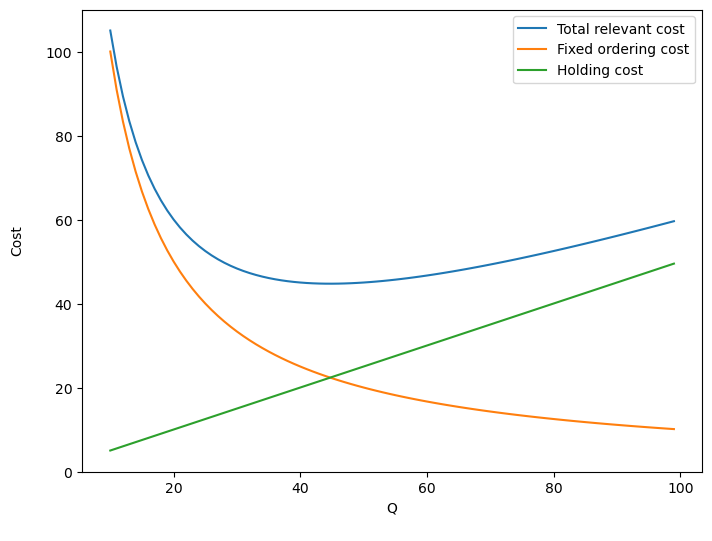

In [4]:
instance = {"K": 100, "h": 1, "d": 10, "v": 2}
pb = eoq(**instance)
Qopt = pb.compute_eoq()
print("Economic order quantity: " + '%.2f' % Qopt)
print("Total relevant cost: " + '%.2f' % pb.relevant_cost(Qopt))

plot_eoq(pb, 10, 100)

Economic order quantity: 40.00
Total cost: 130.00


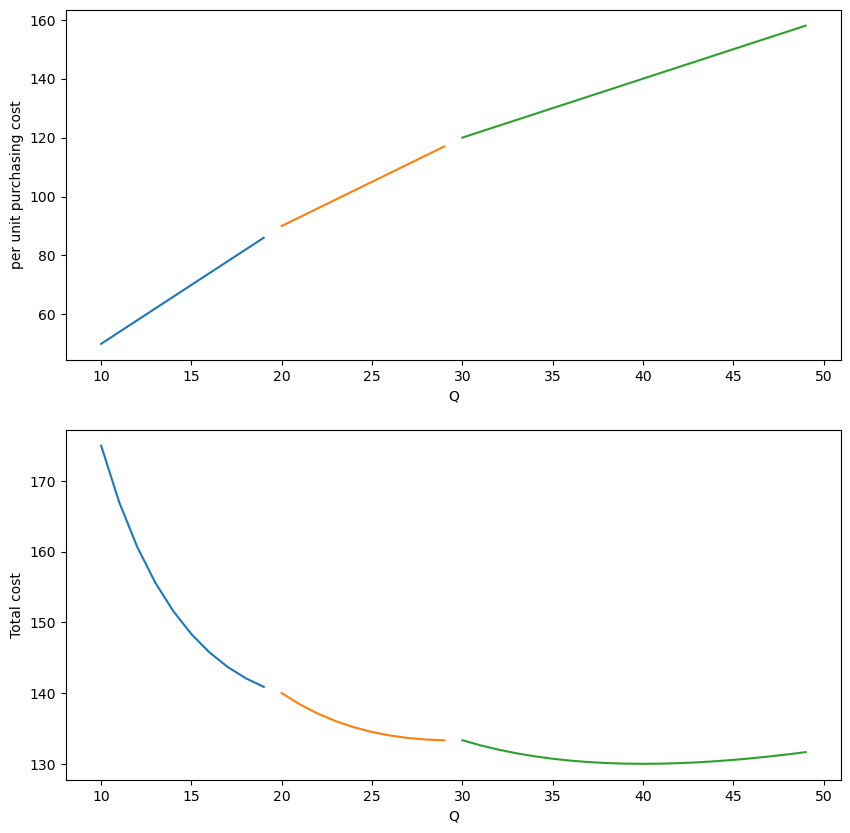

In [5]:
instance_2 = {"K": 100, "h": 1, "d": 10, "b": [10, 20, 30], "v": [5, 4, 3, 2]}
pb_2 = eoq_incremental(**instance_2)
Qopt_2 = pb_2.compute_eoq()
print("Economic order quantity: " + '%.2f' % Qopt_2)
print("Total cost: " + '%.2f' % pb_2.cost(Qopt_2))

plot_discounts(pb_2, 10, 50)